## Collaborative filtering
* 사용자 집단별 추천이 생각만큼 정확한 결과를 내지 못함
* 인구통계적 변수 기준으로 사용자를 나누는 것이 아닌 취향을 기준으로 나누면 개선 가능
* 협업 필터링 Collaborative filtering CF 은 어떤 아이템에 대해 비슷한 취향을 가진 사람들은 다른 아이템에 대해서도 비슷한 취향을 가지고 있을 것이라 가정함


* 협업 필터링은 추천의 대상이 되는 어떠한 user와 취향이 비슷한 이웃 을 찾아내고 이 이웃에 포함된 user들이 선호하는 제품 서비스를 추천 대상으로 설정한다

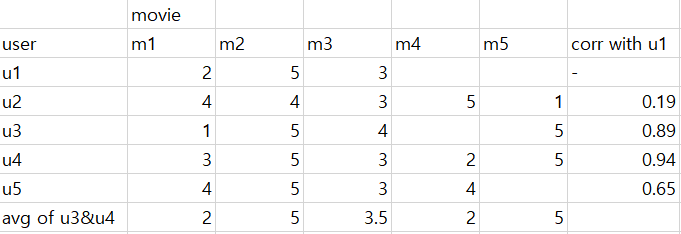

* 위와 같은 예제에서 u1 사용자에게 추천을 하는 경우 아래의 logic을 따를 수 있을 것이다.
    - 우선 u1과 취향이 비슷한 사용자를 찾는다. 취향은 영화에 대한 평가로 나타날 것이므로 각 사용자의 평가의 유사성을 계산한다. correlation을 유사도 지표로 설정한 경우 u3, u4 가 u1과 비슷한 사용자 그룹인 neighbor라 할 수 있다.
    - 그 다음 단계로, u3, u4가 가장 좋게 평가한 영화이면서 u1이 아직 보지 않은 영화를 찾는다. m4, m5가 이에 해당하며 하나의 영화만 추천하는 경우 점수가 더 높은 m5를 추천한다.

----
### 유사도 지표
* 대표적인 유사도 지표로 상관계수, cosine 유사도, 타니모토 coefficient, jaccard 유사도 가 활용된다

* 상관계수
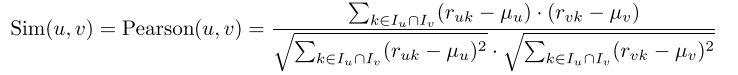

* Cosine 유사도
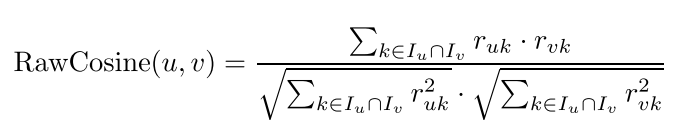

* 타니모토 coefficient | Jaccard coefficient (using for binary data)
https://en.wikipedia.org/wiki/Jaccard_index

    sim(x,y) = c / a + b - c ,

    a : 사용자 x가 1 값을 갖는 아이템의 수

    b : 사용자 y가 1의 값을 갖는 아이템의 수
    
    c : 사용자 x와 y가 공통적으로 1의 값을 갖는 아이템의 수 


* 유사도를 계산했다면 이를 반영한 예측된 평점을 계산할 수 있다.

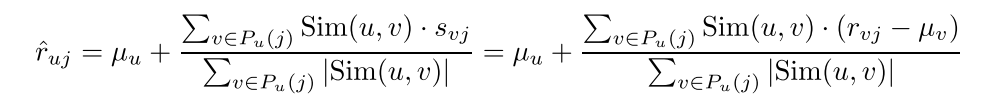


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_repo = '/content/drive/MyDrive/recommender_system/practice/'

import pandas as pd
import numpy as np

Mounted at /content/drive


In [ ]:
#Load dataset
u_cols = ['user_id', 'age', 'sex','occupation', 'zip_code']
users = pd.read_csv(data_repo+'u.user', sep='|', names = u_cols, encoding = 'latin-1')
users = users.set_index('user_id')

i_cols = ['movie_id', 'title', 'release_date', ' video_release_date', 'IMDB_URL', 'unknown',
          'Action','Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romane', 'Sci-FI',
          'Thriller', 'War', 'Western']
movies = pd.read_csv(data_repo+'u.item', sep='|', names= i_cols, encoding='latin-1')
movies = movies.set_index('movie_id')

r_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(data_repo+'u.data', sep='\t', names = r_cols, encoding='latin-1')
ratings = ratings.set_index('user_id')

In [ ]:
# test score - RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true)- np.array(y_pred))**2))

In [ ]:
from sklearn.model_selection import train_test_split
ratings_df = ratings.reset_index().drop('timestamp', axis=1)
movies_df = movies.reset_index().loc[:,['movie_id','title']]

x= ratings_df.copy()
y= ratings_df['user_id']
# 무작위로 unique user를 균일한 size 로 추출하게 됨 -> user 의 특정 column set 이 test set로 구성됨
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = .25, stratify = y, random_state = 7) 

In [ ]:
def score(model):
    # test set에 해당하는 예측치에 대한 RMSE error 계산
    id_pairs = zip(X_test['user_id'], X_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs]) # 모든 user, movie pair에 대해 예측값을 산출
    y_true = np.array(X_test['rating'])

    return RMSE(y_true,y_pred)

rating_matrix = X_train.pivot(index='user_id', columns='movie_id', values = 'rating')
rating_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1629,1631,1634,1635,1636,1637,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1655,1656,1657,1658,1659,1661,1662,1663,1664,1665,1666,1667,1668,1670,1672,1675,1676,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,NaN,3.0,3.0,5.0,4.0,1.0,5.0,NaN,NaN,5.0,NaN,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,NaN,3.0,4.0,NaN,2.0,4.0,1.0,3.0,3.0,NaN,NaN,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
print(matrix_dummy.shape)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
print(user_similarity.shape)
user_similarity = pd.DataFrame(user_similarity, index = rating_matrix.index, columns = rating_matrix.index)
user_similarity.head()

(943, 1632)
(943, 943)


user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.122120,0.062416,0.036915,0.313070,0.323045,0.332519,0.252372,0.084758,0.274040,0.234021,0.229123,0.323949,0.272352,0.137995,0.293637,0.127877,0.352974,0.143649,0.221357,0.178028,0.374523,0.316889,0.215732,0.227275,0.221875,0.069728,0.252376,0.099997,0.176970,0.080960,0.186483,0.013696,0.002183,0.032090,0.012620,0.193556,0.154189,0.030537,0.051318,...,0.093506,0.081280,0.094258,0.226422,0.211938,0.107632,0.174333,0.217610,0.188439,0.293766,0.074741,0.047655,0.463129,0.073250,0.185568,0.292978,0.043677,0.251273,0.310475,0.123555,0.189008,0.073994,0.050850,0.194910,0.185873,0.163858,0.216950,0.112426,0.273136,0.366499,0.244980,0.085903,0.251912,0.164752,0.175125,0.111705,0.249690,0.142287,0.188493,0.295020
2,0.122120,1.000000,0.131901,0.096137,0.079685,0.189115,0.089998,0.022561,0.042906,0.133550,0.063299,0.078058,0.181320,0.191352,0.374863,0.102134,0.226743,0.102227,0.073626,0.029726,0.138221,0.043423,0.128774,0.152681,0.151187,0.351378,0.119562,0.095246,0.094621,0.115525,0.066393,0.131303,0.049137,0.116384,0.045767,0.103494,0.066642,0.033905,0.170965,0.210424,...,0.167334,0.118124,0.130620,0.174472,0.062073,0.115129,0.167484,0.022762,0.031282,0.141529,0.010568,0.159114,0.093046,0.168690,0.014871,0.309910,0.258402,0.102537,0.065735,0.183220,0.214556,0.029362,0.214459,0.092616,0.048899,0.067188,0.223280,0.285515,0.050147,0.069740,0.129051,0.202017,0.266348,0.277049,0.201352,0.176834,0.091703,0.135681,0.136187,0.065540
3,0.062416,0.131901,1.000000,0.235145,0.000000,0.047999,0.057630,0.072380,0.022942,0.026675,0.052730,0.089437,0.147622,0.041932,0.075636,0.076587,0.025258,0.008990,0.049209,0.047683,0.145790,0.045303,0.036239,0.068031,0.049696,0.192976,0.000000,0.075702,0.142293,0.091690,0.175034,0.154868,0.344053,0.071804,0.252357,0.048420,0.016197,0.082646,0.206002,0.349965,...,0.056463,0.188916,0.083714,0.119249,0.060345,0.015390,0.032313,0.012171,0.045997,0.089760,0.000000,0.347025,0.045228,0.000000,0.000000,0.191542,0.321473,0.085871,0.054186,0.077255,0.073004,0.117745,0.199078,0.055641,0.081142,0.049396,0.011844,0.107341,0.000000,0.048115,0.023312,0.055393,0.093156,0.083707,0.108634,0.034876,0.148960,0.108821,0.138479,0.035044
4,0.036915,0.096137,0.235145,1.000000,0.000000,0.039897,0.060627,0.100272,0.000000,0.038376,0.091736,0.061950,0.062779,0.000000,0.125739,0.065736,0.000000,0.014945,0.073041,0.044039,0.164976,0.051483,0.049756,0.186810,0.070567,0.130517,0.000000,0.137648,0.065708,0.112816,0.056352,0.075091,0.324977,0.155426,0.174801,0.093431,0.033657,0.044320,0.167218,0.132534,...,0.094768,0.128904,0.037277,0.078946,0.084252,0.000000,0.038369,0.000000,0.043447,0.099001,0.000000,0.189974,0.036224,0.000000,0.000000,0.144633,0.223861,0.046326,0.079124,0.034157,0.066822,0.108745,0.194434,0.082382,0.072598,0.018663,0.009845,0.041307,0.019347,0.049992,0.024221,0.047962,0.000000,0.158131,0.099395,0.040262,0.146710,0.138193,0.143881,0.036411
5,0.313070,0.079685,0.000000,0.000000,1.000000,0.182160,0.289190,0.237454,0.046112,0.150184,0.243419,0.099181,0.252792,0.141052,0.054520,0.218483,0.105036,0.221326,0.056520,0.180668,0.148868,0.376005,0.271983,0.070054,0.268203,0.118104,0.048162,0.316722,0.023377,0.141817,0.030072,0.131668,0.000000,0.003318,0.012721,0.000000,0.168389,0.099781,0.000000,0.003627,...,0.020470,0.031268,0.064984,0.111762,0.118155,0.035555,0.221398,0.250534,0.136796,0.181468,0.029372,0.000000,0.262797,0.085386,0.095525,0.145106,0.000000,0.171226,0.364598,0.120305,0.091560,0.059846,0.000000,0.249900,0.088733,0.225338,0.153670,0.057314,0.256048,0.280960,0.272087,0.047351,0.077125,0.101266,0.097994,0.074128,0.203906,0.080452,0.144076,0.21027

In [ ]:
# 주어진 영화의 가중 평균 계산
def CF_simple(user_id, movie_id):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy() # 특정 user와 다른 user 간 유사도
        movie_ratings = rating_matrix[movie_id].copy() # 특정 영화에 대한 모든 user 평점
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index # 특정 영화에 대해 평가하지 않은 user id 목록
        movie_ratings = movie_ratings.dropna() # 해당 영화에 대한 평점 중 NaN 제거
        sim_scores = sim_scores.drop(none_rating_idx) # 해당 영화를 평가하지 않은 user들을 유사도 목록에서 제외 
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() 
    else:
        mean_rating = 3.
    return mean_rating

In [ ]:
score(CF_simple)

1.0208743992641496

### Exercise1
* 위 코드를 수정해 cosine 유사도 대신 pearson correlation 을 활용한 코드를 작성하고 RMSE를 계산해보기

In [ ]:
matrix_dummy = rating_matrix.copy().fillna(0.)
user_similarity_corr =  matrix_dummy.T.corr(method='pearson')
print(user_similarity_corr.shape)
user_similarity_corr = pd.DataFrame(user_similarity_corr, index = matrix_dummy.index, columns = matrix_dummy.index)
user_similarity_corr.head()

(943, 943)


user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.074086,0.015554,0.003056,0.250675,0.248874,0.227081,0.215937,0.055162,0.197767,0.156291,0.192045,0.196637,0.220799,0.078679,0.231935,0.097642,0.268631,0.120040,0.187548,0.101506,0.327203,0.255065,0.170104,0.178670,0.164342,0.037652,0.206621,0.064086,0.141477,0.042333,0.152248,-0.022116,-0.030207,-0.002230,-0.018295,0.151531,0.089090,-0.002502,0.012420,...,0.049629,0.040214,0.052628,0.154992,0.163513,0.076325,0.131684,0.161756,0.148339,0.235640,0.045363,0.013331,0.388609,0.036011,0.126809,0.213971,0.008728,0.196672,0.254889,0.068662,0.136581,0.037724,0.021646,0.130846,0.156144,0.124053,0.176438,0.062810,0.186037,0.306670,0.170077,0.045350,0.185950,0.130611,0.115396,0.067644,0.194254,0.116580,0.136610,0.229455
2,0.074086,1.000000,0.111260,0.081092,0.040617,0.149816,0.025847,-0.002260,0.027401,0.092356,0.019478,0.055148,0.119269,0.163736,0.354689,0.065419,0.213168,0.049979,0.059681,0.007528,0.101452,0.008083,0.092149,0.128301,0.125069,0.328936,0.104794,0.067806,0.076779,0.095954,0.047320,0.112355,0.033024,0.103328,0.029722,0.090564,0.042309,-0.001144,0.157825,0.195089,...,0.147862,0.099077,0.111221,0.139633,0.033852,0.099519,0.146111,-0.010722,0.007161,0.108258,-0.005117,0.144745,0.036675,0.152574,-0.019020,0.277667,0.245768,0.071142,0.029819,0.158832,0.190096,0.010825,0.203143,0.058661,0.030300,0.044933,0.202950,0.266309,-0.001908,0.028720,0.089623,0.184900,0.236959,0.261958,0.174057,0.156983,0.059571,0.121933,0.109500,0.025021
3,0.015554,0.111260,1.000000,0.223780,-0.038564,0.004988,-0.002894,0.051195,0.008652,-0.015868,0.012945,0.069083,0.088872,0.012353,0.048560,0.042673,0.009536,-0.044752,0.036243,0.028080,0.113387,0.013644,-0.000582,0.043927,0.023386,0.167763,-0.015290,0.050523,0.127065,0.073581,0.159875,0.138252,0.334297,0.059304,0.241219,0.035897,-0.006872,0.052897,0.194616,0.338586,...,0.036587,0.173133,0.065288,0.085781,0.034945,-0.000383,0.009967,-0.018273,0.024630,0.058018,-0.014279,0.337084,-0.009082,-0.017598,-0.030960,0.156498,0.310997,0.057181,0.021538,0.052485,0.047016,0.102614,0.188509,0.023852,0.064969,0.028989,-0.011420,0.085775,-0.050012,0.010357,-0.017170,0.037077,0.059793,0.066345,0.081222,0.013923,0.122139,0.095942,0.114623,-0.002668
4,0.003056,0.081092,0.223780,1.000000,-0.027271,0.009611,0.019687,0.085875,-0.010360,0.009159,0.065955,0.047195,0.014208,-0.021897,0.108141,0.041888,-0.011418,-0.022471,0.064059,0.030152,0.144012,0.029524,0.024529,0.172414,0.052595,0.111774,-0.010813,0.121462,0.053957,0.100365,0.044075,0.062259,0.317665,0.147327,0.165933,0.084951,0.017686,0.022539,0.158611,0.121710,...,0.081359,0.116961,0.023606,0.054598,0.066992,-0.011336,0.022720,-0.021811,0.028348,0.077422,-0.010097,0.181021,-0.002018,-0.012445,-0.021894,0.119604,0.215199,0.025297,0.057187,0.015891,0.048526,0.097913,0.186727,0.061062,0.061046,0.003782,-0.006625,0.024991,-0.014812,0.023780,-0.004147,0.034924,-0.026433,0.146897,0.080218,0.025568,0.128372,0.129306,0.127556,0.010084
5,0.250675,0.040617,-0.038564,-0.027271,1.000000,0.114813,0.208277,0.207387,0.021532,0.082881,0.185496,0.063482,0.151661,0.093313,0.004521,0.166125,0.080195,0.146127,0.034010,0.151591,0.088857,0.338782,0.221550,0.026916,0.232337,0.067648,0.022530,0.283999,-0.007721,0.112087,-0.001839,0.101947,-0.027600,-0.021013,-0.014155,-0.023852,0.134114,0.046840,-0.026332,-0.028068,...,-0.016565,-0.002473,0.031600,0.049459,0.075481,0.008109,0.190187,0.209217,0.102763,0.129452,0.004795,-0.028161,0.187534,0.057234,0.045196,0.073369,-0.028438,0.124214,0.324936,0.078034,0.045766,0.031320,-0.024412,0.204250,0.060664,0.196852,0.118546,0.016511,0.189733,0.229076,0.217500,0.014453,0.014977,0.

In [ ]:
user_similarity_corr.tail()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
939,0.067644,0.156983,0.013923,0.025568,0.038385,0.059161,0.039418,0.044991,-0.014858,0.011174,0.047142,0.110608,0.023235,0.048349,0.232884,0.048374,0.042731,-0.008815,0.028140,0.120495,0.123796,0.056992,0.036701,0.072909,0.065992,0.164636,0.127501,0.030926,0.001701,0.032338,-0.018681,0.189403,-0.015538,-0.013770,0.067563,-0.013428,0.073892,0.090876,0.023700,0.011498,...,0.060288,0.185616,0.100002,0.126328,0.001085,-0.016259,0.176585,-0.031284,0.008769,0.055127,-0.014482,0.006492,0.001278,0.105846,-0.031402,0.136217,0.024955,0.167886,0.072312,0.131944,0.086102,-0.017450,0.078521,0.126125,-0.000984,-0.021774,0.102913,0.186923,-0.019235,0.069602,0.038924,0.172687,0.119923,0.096902,0.371956,1.000000,0.044429,0.227147,0.008307,0.076820
940,0.194254,0.059571,0.122139,0.128372,0.158268,0.219617,0.146769,0.236090,0.122500,0.231085,0.199302,0.172529,0.192354,0.245218,0.156309,0.254135,0.175270,0.154922,0.173427,0.195304,0.082255,0.218414,0.235774,0.243291,0.186532,0.230220,0.027773,0.224369,0.112802,0.320024,0.056481,0.157676,0.115685,0.026881,0.123476,0.036825,0.159280,0.047647,0.228076,0.148584,...,0.051974,0.221567,0.050115,0.082919,0.210744,0.041474,0.232056,0.263614,0.115919,0.322817,0.036505,0.146530,0.214161,0.075696,0.101956,0.183549,0.159125,0.155724,0.214301,0.055662,0.158858,0.006116,0.223514,0.105411,0.135360,0.154218,0.099517,0.139001,0.193150,0.185761,0.234028,0.094699,0.097614,0.126065,0.109756,0.044429,1.000000,0.112067,0.172559,0.159496
941,0.116580,0.121933,0.095942,0.129306,0.057338,0.095216,-0.002629,0.085446,-0.009981,0.025664,0.027028,0.063099,0.039409,0.120738,0.053435,0.080425,0.212670,-0.037095,0.055865,0.106411,0.173421,0.116418,0.086572,0.149458,0.164056,0.193385,0.070234,0.042007,0.000128,0.042635,-0.012549,0.169986,0.047648,-0.009249,0.113898,0.031068,0.081068,-0.015964,0.094598,0.079230,...,0.076826,0.223149,0.198109,0.119704,0.092244,-0.010922,0.186564,-0.021014,0.023806,0.118614,-0.009728,0.075990,0.059811,0.035969,0.008226,0.194883,0.100427,0.130586,0.132708,0.107074,0.111611,-0.011722,0.064622,0.153285,0.066609,0.024668,0.136287,0.067253,-0.002272,0.028494,0.007986,0.199109,0.196513,0.146523,0.265864,0.227147,0.112067,1.000000,0.119986,0.073433
942,0.136610,0.109500,0.114623,0.127556,0.101509,0.169776,0.123670,0.199318,0.072879,0.147157,0.019974,0.132014,0.183121,0.075808,0.099884,0.243196,0.017234,0.145104,0.141530,0.093980,0.028234,0.127075,0.151342,0.097992,0.211529,0.126800,-0.019889,0.176215,0.146194,0.208568,0.017916,0.037110,0.069035,-0.003191,0.151444,0.028762,0.104014,0.026535,0.076388,0.171327,...,0.028061,0.159562,0.042135,0.049919,0.143690,-0.020851,0.113407,0.159201,0.147818,0.171248,0.068988,0.072272,0.061538,0.048791,0.047371,0.114433,0.161654,0.109379,0.143238,0.051515,0.116834,-0.022379,0.088267,0.030710,0.039922,0.164659,0.086342,0.106786,0.135697,0.047349,0.152229,0.074264,0.013211,0.093875,-0.002426,0.008307,0.172559,0.119986,1.000000,0.107172
943,0.229455,0.025021,-0.002668,0.010084,0.154295,0.141434,0.196880,0.138408,0.019913,0.094269,0.167075,0.180771,0.164919,0.107732,0.050428,0.205758,0.054798,0.137551,0.056521,0.114992,0.042865,0.209065,0.106611,0.229465,0.071916,0.070871,0.061358,0.190298,0.026106,-0.013869,-0.021617,0.031819,-0.028158,-0.024953,-0.027934,-0.024334,0.251767,0.067725,-0.026864,-0.032490,...,0.134168,0.128102,0.039130,0.140876,0.174076,-0.029464,0.131317,0.085731,0.055708,0.165286,0.038413,-0.028730,0.265011,0.064502,0.022314,0.098949,-0.029013,0.196511,0.221535,0.086364,0.169737,0.033253,-0.001274,0.190192,0.045860,0.147184,0.076067,0.020052,0.063621,0.318695,0.091133,0.154692,0.027945,-0.00965

In [ ]:
# pearson corelation 
def CF_simple_corr(user_id, movie_id):
    if movie_id in rating_matrix:
        sim_scores = user_similarity_corr[user_id].copy() # 특정 user와 다른 user 간 유사도
        movie_ratings = rating_matrix[movie_id].copy() # 특정 영화에 대한 모든 user 평점
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index # 특정 영화에 대해 평가하지 않은 user id 목록
        movie_ratings = movie_ratings.dropna() # 해당 영화에 대한 평점 중 NaN 제거
        sim_scores = sim_scores.drop(none_rating_idx) # 해당 영화를 평가하지 않은 user들을 유사도 목록에서 제외 
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum() 
    else:
        mean_rating = 3.
    return mean_rating

In [ ]:
score(CF_simple_corr)

1.0551670003128153

----
### Collaborative filtering with considering neighborhood
* 이웃을 정하는 기준
    - 추천 대상 user와 가장 유사한 K명을 선택하는 K-nearest-neighobrs 방법
    - 유사도의 metric 값에 대한 threshold를 설정하는 방법
* 일반적으로 Thresholding 방법이 knn보다 정확하기는 하지만 정해진 기준을 넘는 사용자가 없어서 추천을 하지 못하는 경우 때문에 KNN이 무난하게 많이 쓰임


In [ ]:
def score(model, neighbor_size):
    # test set에 해당하는 예측치에 대한 RMSE error 계산
    id_pairs = zip(X_test['user_id'], X_test['movie_id'])
    if neighbor_size == None:
        y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])    
    else:
        y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs]) # 모든 user, movie pair에 대해 예측값을 산출 + neighbor size param 추가
    y_true = np.array(X_test['rating'])

    return RMSE(y_true,y_pred)

def cf_knn(user_id, movie_id, neighbor_size = 0):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size == 0:
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
        else:
            if len(sim_scores) >1: # 영화를 평가한 사람이 최소 2명 이상인 경우
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores) # ascending sort
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
    
    return mean_rating

In [ ]:
score(cf_knn, neighbor_size=30)

1.0124999176649374

In [ ]:
# recommendation with full matrix
rating_matrix = ratings.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index = rating_matrix.index , columns = rating_matrix.index)

def recommend_movie(user_id, n_items, neighbor_size = 30):
    user_movie = rating_matrix.loc[user_id].copy()
    for movie in rating_matrix:
        if pd.notnull(user_movie.loc[movie]): # 해당 영화가 시청한 영화인 경우
            user_movie.loc[movie] = 0
        else:
            user_movie.loc[movie] = cf_knn(user_id, movie, neighbor_size)
    movie_sort = user_movie.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']
    return recommendations

In [ ]:
recommend_movie(user_id=42, n_items=5, neighbor_size=30)

movie_id
1500               Santa with Muscles (1996)
1189                      Prefontaine (1997)
1656                      Little City (1998)
1293                         Star Kid (1997)
1467    Saint of Fort Washington, The (1993)
Name: title, dtype: object

----
### Finding best neighbor size
* 이웃의 수는 hyper-parameter로 모델의 성능이 값에 따라 달라질 수 있고 overfitting issue 도 고려해야 한다.
* 일반적으로 최적의 이웃 크기가 존재하지만, 구체적으로 얼마가 최적의 크기인지는 domain에 따라 차이가 있다.
* parameter search 를 통해 다양한 값에 따른 성능 평가를 해야 한다.

In [ ]:
rating_matrix = X_train.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index = rating_matrix.index, columns = rating_matrix.index)

for nb in [10,20,30,40,50,60]:
    print("Neighbor szie = %d : RMSE = %.4f" % (nb, score(cf_knn, nb)))

Neighbor szie = 10 : RMSE = 1.0284
Neighbor szie = 20 : RMSE = 1.0147
Neighbor szie = 30 : RMSE = 1.0125
Neighbor szie = 40 : RMSE = 1.0117
Neighbor szie = 50 : RMSE = 1.0122
Neighbor szie = 60 : RMSE = 1.0133


### rating 조정
* user 마다 rating을 측정하는 방식이 개인마다 이질적일 수 있기 때문에 이를 점수 예측치에 반영해주면 정확도를 더 높일 수 있다.
* 간단한 방법은 user의 평균 점수에 예측값을 더해주는 방식인데 단 예측값은 mean centering 으로 처리된 값인 점이 기존의 예측방식과 다르다
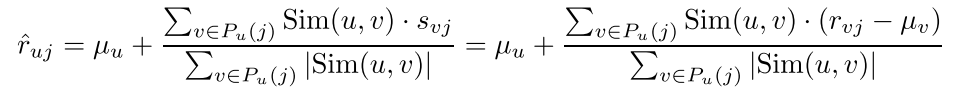

In [ ]:
rating_matrix = X_train.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index = rating_matrix.index, columns = rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1) # average score by user
rating_bias = (rating_matrix.T - rating_mean).T # mean centering
rating_bias

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1629,1631,1634,1635,1636,1637,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1655,1656,1657,1658,1659,1661,1662,1663,1664,1665,1666,1667,1668,1670,1672,1675,1676,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,-0.500000,NaN,-0.5000,-0.5,1.5,0.5000,-2.5000,1.5000,NaN,NaN,1.500000,NaN,1.500000,1.500000,1.5,-0.5,0.5,1.500000,0.5,-2.500000,0.500000,NaN,-0.500000,0.500000,NaN,-1.5,0.5,-2.500000,-0.5,-0.500000,NaN,NaN,-1.5,-2.5,-1.5,-1.5,-0.500000,0.5,-0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.326087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.673913,NaN,NaN,0.326087,0.326087,NaN,NaN,NaN,NaN,-0.673913,NaN,NaN,NaN,NaN,NaN,0.326087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.236641,0.236641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236641,NaN,NaN,1.236641,0.236641,NaN,NaN,NaN,1.236641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.236641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.756757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,-1.5625,NaN,NaN,0.4375,1.4375,-0.5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def cf_knn_bias(user_id, movie_id, neighbor_size = 0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_bias[movie_id].copy()
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size ==0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction += rating_mean[user_id]
        else:
            if len(sim_scores)> 1:
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction += rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

In [ ]:
score(cf_knn_bias,30)

0.951236511682735

### Exercise 2
* bias를 반영한 CF 로 사용자 ID를 지정하면 해당 사용자를 위한 5개의 영화 추천을 하는 함수를 작성하고 기존의 CF와 결과를 비교해보기

In [ ]:
# recommendation with full matrix
rating_matrix = ratings.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index = rating_matrix.index , columns = rating_matrix.index)
rating_mean = rating_matrix.mean(axis=1) # average score by user
rating_bias = (rating_matrix.T - rating_mean).T # mean centering

def recommend_movie(user_id, n_items, neighbor_size = 30):
    user_movie = rating_matrix.loc[user_id].copy()
    for movie in rating_matrix:
        if pd.notnull(user_movie.loc[movie]): # 해당 영화가 시청한 영화인 경우
            user_movie.loc[movie] = 0
        else:
            user_movie.loc[movie] = cf_knn_bias(user_id, movie, neighbor_size)
    movie_sort = user_movie.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']
    return recommendations

recommend_movie(user_id=42, n_items=5, neighbor_size=30)

movie_id
1463                        Boys, Les (1997)
1467    Saint of Fort Washington, The (1993)
1500               Santa with Muscles (1996)
1293                         Star Kid (1997)
1642                Some Mother's Son (1996)
Name: title, dtype: object

-----
### Significance weighting
* user 1 과 user 2 간의 유사도를 계산할 때 기존에는 이 둘의 공통 평가 item rating 을 활용했다. 이 상황에서 공통 item의 수가 2개인 경우(user1&user2)와 20개인 경우(user1&user11)가 있다고 할 때 유사도의 신뢰도는 공통 item이 20개인 경우라 할 수 있다.
* 신뢰도를 반영하기 위해 유사도에 가중치를 주는 방식을 활용할 수 있다. 단, 예측값이 매우 민감하게 반응하기 때문에 공통 아이템의 수를 가중치로 이용하게 되면 정보를 잃을 가능성이 크다.
* 대안적으로 신뢰도가 일정 이상인 경우만 예측치 계산을 바꾸는 방법이 있다.
* 유사한 방법으로 예측값을 계산하는 item에 대해 평가한 user의 수가 일정 수 이상인 경우 예측치를 계산하도록 하는 방법이 있다. 


### change prediction value
* 위의 방법 외에 RMSE를 개선하기 위한 방법으로 최종 예측값을 수정하는 것을 활용할 수 있다.
* MovieLens 데이터의 경우 1~5의 점수가 매겨지는데 예측값이 이 범위를 범어나는 경우 RMSE가 커질 가능성이 있기 때문에 이를 수정하는 과정을 추가하면 조금 더 개선이 가능하다.

In [ ]:
rating_matrix = X_train.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index = rating_matrix.index, columns = rating_matrix.index)

rating_mean = rating_matrix.mean(axis=1) # average score by user
rating_bias = (rating_matrix.T - rating_mean).T # mean centering

rating_binary1 = np.array((rating_matrix>0).astype(float))
rating_binary2 = rating_binary1.T
counts = np.dot(rating_binary1, rating_binary2)
counts = pd.DataFrame(counts, index= rating_matrix.index, columns = rating_matrix.index).fillna(0) # user 간 공통 평가 item의 count matrix
counts.head() 

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,204.0,10.0,7.0,3.0,51.0,55.0,83.0,20.0,4.0,41.0,40.0,19.0,99.0,30.0,19.0,38.0,8.0,69.0,9.0,18.0,26.0,45.0,48.0,21.0,22.0,27.0,4.0,24.0,7.0,15.0,7.0,14.0,2.0,1.0,5.0,1.0,16.0,29.0,2.0,4.0,...,9.0,6.0,8.0,34.0,21.0,6.0,17.0,27.0,16.0,39.0,5.0,2.0,93.0,5.0,24.0,52.0,2.0,31.0,43.0,12.0,19.0,6.0,3.0,28.0,12.0,12.0,21.0,13.0,49.0,57.0,38.0,8.0,33.0,12.0,25.0,11.0,31.0,7.0,20.0,44.0
2,10.0,46.0,8.0,3.0,4.0,17.0,12.0,2.0,2.0,10.0,5.0,3.0,24.0,11.0,20.0,7.0,7.0,7.0,2.0,2.0,10.0,3.0,9.0,7.0,7.0,19.0,3.0,5.0,4.0,5.0,2.0,6.0,2.0,3.0,2.0,3.0,3.0,4.0,6.0,8.0,...,6.0,5.0,5.0,13.0,3.0,4.0,8.0,1.0,1.0,10.0,1.0,6.0,9.0,6.0,1.0,24.0,8.0,8.0,4.0,10.0,11.0,1.0,7.0,6.0,2.0,3.0,9.0,12.0,4.0,3.0,10.0,8.0,18.0,10.0,11.0,6.0,6.0,4.0,7.0,4.0
3,7.0,8.0,41.0,7.0,0.0,5.0,9.0,4.0,1.0,2.0,5.0,3.0,26.0,2.0,5.0,6.0,1.0,1.0,2.0,2.0,12.0,3.0,3.0,4.0,2.0,11.0,0.0,5.0,6.0,3.0,6.0,6.0,9.0,3.0,7.0,2.0,1.0,5.0,8.0,11.0,...,3.0,6.0,3.0,11.0,4.0,1.0,4.0,1.0,2.0,8.0,0.0,10.0,4.0,0.0,0.0,17.0,10.0,4.0,3.0,5.0,5.0,4.0,6.0,3.0,3.0,2.0,2.0,5.0,0.0,3.0,2.0,2.0,6.0,5.0,6.0,2.0,10.0,3.0,7.0,2.0
4,3.0,3.0,7.0,18.0,0.0,3.0,6.0,4.0,0.0,2.0,6.0,2.0,8.0,0.0,4.0,3.0,0.0,1.0,1.0,3.0,8.0,2.0,2.0,6.0,2.0,5.0,0.0,4.0,2.0,2.0,2.0,2.0,6.0,2.0,3.0,2.0,1.0,2.0,3.0,3.0,...,3.0,3.0,1.0,4.0,3.0,0.0,1.0,0.0,1.0,5.0,0.0,5.0,3.0,0.0,0.0,8.0,5.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,3.0,4.0,1.0,6.0,3.0,5.0,2.0
5,51.0,4.0,0.0,0.0,131.0,24.0,57.0,16.0,3.0,20.0,36.0,8.0,72.0,12.0,8.0,21.0,4.0,39.0,2.0,13.0,22.0,37.0,34.0,6.0,18.0,11.0,1.0,23.0,2.0,8.0,2.0,7.0,0.0,1.0,2.0,0.0,10.0,24.0,0.0,1.0,...,4.0,1.0,3.0,13.0,9.0,1.0,11.0,24.0,9.0,20.0,4.0,0.0,45.0,4.0,12.0,19.0,0.0,18.0,42.0,9.0,7.0,3.0,0.0,29.0,5.0,12.0,14.0,3.0,35.0,42.0,33.0,3.0,9.0,4.0,11.0,5.0,17.0,3.0,12.0,29.0


In [ ]:
def cf_knn_bias_sig(user_id,movie_id, neighbor_size = 0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_bias[movie_id].copy()

        no_rating = movie_ratings.isnull()
        common_counts = counts[user_id]
        low_significance = common_counts < SIG_LEVEL

        none_rating_idx = movie_ratings[no_rating | low_significance].index # significance 에 대한 or 조건 추가
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size ==0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction += rating_mean[user_id]
        else:
            if len(sim_scores)> MIN_RATING : # item 평가 user의 수 filtering
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction += rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

SIG_LEVEL = 3
MIN_RATING = 2

In [ ]:
score(cf_knn_bias_sig, 30)

0.9512326023353698

### Exercise 3
* 위 CF 함수를 수정해 예측값이 1이하면 1로, 5이상이면 5로 수정하는 코드를 추가하고 RMSE 결과를 비교해보기

In [ ]:
def cf_knn_bias_sig(user_id,movie_id, neighbor_size = 0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_bias[movie_id].copy()

        no_rating = movie_ratings.isnull()
        common_counts = counts[user_id]
        low_significance = common_counts < SIG_LEVEL

        none_rating_idx = movie_ratings[no_rating | low_significance].index # significance 에 대한 or 조건 추가
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

        if neighbor_size ==0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction += rating_mean[user_id]
        else:
            if len(sim_scores)> MIN_RATING : # item 평가 user의 수 filtering
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction += rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]

    if prediction < 1 : prediction=1
    elif prediction >5 : prediction =5

    return prediction

SIG_LEVEL = 3
MIN_RATING = 2
score(cf_knn_bias_sig, 30)

0.9501728148889717

----
## Item based Collaborative Filtering
* Item-based Collaborative Filtering 은 item 별 평가 패턴을 바탕으로 item간의 유사도를 계산해 사용자의 특정 아이템에 대한 예측 평점을 계산하는 방식이다
* user based CF 는 사용자로별로 맞춤형 추천을 하기 때문에 데이터가 풍부한 경우 정확한 추천이 가능하다. 
* item based CF 는 같은 조건에서 user-based 보다 정확도가 떨어지지만 계산이 효율적이라는 장점을 가진다.
* user based CF는 정확하지만 가끔 터무니없는 추천이 되는 경우도 있는데 item based CF는 이러한 위험이 적다
* user-based CF는 user에 관한 데이터가 조금만 바뀌어도 update를 해야하지만 item based CF는 update를 자주 하지 않아도 된다.
* 데이터 크기가 상대적으로 작고 각 user에 대한 충분한 정보가 있는 경우 user-based CF가 알맞고, 데이터가 크거나 각 user에 대한 정보가 충분치 못한 경우 item-based CF가 적절한 방법이 될 수 있다.
* 특히 e-commerce와 같이 대규모 데이터를 다뤄야 하는 상황에서는 item-based CF가 사용되며 대표적으로 Amazon의 추천 시스템에서 item-based CF가 제안되었다.

* item 간 유사도 역시 cosine 유사도를 많이 활용하며 공통적으로 평가가 매겨진 item 의 평가 간 유사도를 계산하고 이에 대한 가중 평균으로 예측값을 산출한다.

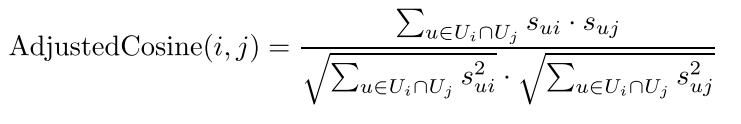
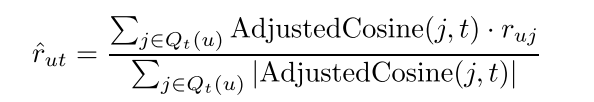

In [ ]:
rating_matrix = X_train.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index = rating_matrix_t.index, columns = rating_matrix_t.index)
item_similarity.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1629,1631,1634,1635,1636,1637,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1655,1656,1657,1658,1659,1661,1662,1663,1664,1665,1666,1667,1668,1670,1672,1675,1676,1680,1681,1682
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.283944,0.221048,0.377427,0.187929,0.061502,0.478090,0.369214,0.400110,0.188752,0.363872,0.360739,0.358007,0.268504,0.446237,0.160602,0.209716,0.020610,0.127399,0.175871,0.262193,0.417069,0.254941,0.360054,0.450943,0.180842,0.167254,0.444938,0.259146,0.102009,0.349874,0.174722,0.199875,0.085482,0.124667,0.060992,0.042692,0.271710,0.200800,0.155993,...,0.053215,0.000000,0.000000,0.000000,0.000000,0.000000,0.031166,0.000000,0.000000,0.000000,0.056988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053215,0.000000,0.000000,0.047597,0.066519,0.039911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.053215
2,0.283944,1.000000,0.144326,0.405639,0.199418,0.051253,0.334087,0.222967,0.148331,0.130390,0.325613,0.330390,0.164013,0.090835,0.181579,0.109980,0.223976,0.069561,0.020406,0.048341,0.234935,0.344698,0.180086,0.312609,0.235200,0.183226,0.288376,0.319389,0.414391,0.059186,0.365824,0.083713,0.343967,0.082970,0.127950,0.129163,0.113525,0.436257,0.241035,0.204991,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089803,0.000000,0.119737,0.000000,0.000000,0.119737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089803,0.000000,0.000000,0.0,0.089803,0.000000
3,0.221048,0.144326,1.000000,0.260540,0.138414,0.038101,0.320198,0.180896,0.217746,0.150012,0.304112,0.243866,0.161196,0.155597,0.186950,0.083704,0.382575,0.105337,0.045749,0.115608,0.126135,0.219792,0.190357,0.249119,0.223639,0.140041,0.189365,0.225116,0.193586,0.107312,0.207545,0.124725,0.311658,0.121489,0.000000,0.000000,0.016229,0.187197,0.253390,0.118767,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011728,0.111264,0.000000,0.000000,0.000000,0.074176,0.111264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.111264
4,0.377427,0.405639,0.260540,1.000000,0.215301,0.066427,0.384984,0.402347,0.342276,0.201757,0.480943,0.457488,0.328177,0.189629,0.270258,0.165812,0.332911,0.053663,0.116043,0.169380,0.223835,0.410899,0.342757,0.290927,0.361925,0.350258,0.306343,0.413323,0.338029,0.183418,0.360915,0.247208,0.394287,0.133544,0.068337,0.131717,0.133392,0.346668,0.394115,0.291824,...,0.041568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077189,0.000000,0.000000,0.083135,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062351,0.103919,0.103919,0.0,0.062351,0.000000
5,0.187929,0.199418,0.138414,0.215301,1.000000,0.045785,0.270047,0.211663,0.208770,0.019534,0.266031,0.271934,0.133049,0.091634,0.199654,0.137300,0.254639,0.081051,0.076991,0.062876,0.170329,0.249834,0.168748,0.182124,0.219242,0.163585,0.194887,0.203264,0.238783,0.114377,0.231945,0.069143,0.228703,0.052732,0.017202,0.235154,0.061052,0.257659,0.221277,0.166681,...,0.139516,0.069758,0.069758,0.069758,0.069758,0.069758,0.043577,0.069758,0.069758,0.000000,0.043943,0.031197,0.069758,0.069758,0.069758,0.069758,0.069758,0.069758,0.069758,0.000000,0.000000,0.000000,0.104637,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.104637


In [ ]:
def itemCF(user_id, movie_id):
    if movie_id in item_similarity:
        sim_scores = item_similarity[movie_id]
        user_rating = rating_matrix_t[user_id]
        non_rating_idx = user_rating[user_rating.isnull()].index
        user_rating = user_rating.dropna()
        sim_scores = sim_scores.drop(non_rating_idx)
        mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

In [ ]:
score(itemCF, neighbor_size=None)

1.0214756753057226

### Exercise 4
* neighbor size 를 고려한 Item-based CF 함수를 만들고 RSME를 계산해보기
* 특정 user id를 지정하면 5개의 영화를 추천하는 함수를 Item-based CF를 활용해 만들고 user-based 와 결과를 비교해보기

In [ ]:
def itemCF_knn(user_id, movie_id, neighbor_size = 0):
    if movie_id in item_similarity:
        sim_scores = item_similarity[movie_id]
        user_rating = rating_matrix_t[user_id]
        non_rating_idx = user_rating[user_rating.isnull()].index
        user_rating = user_rating.dropna()
        sim_scores = sim_scores.drop(non_rating_idx)
        
        if neighbor_size == 0:
            mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
        else:
            if len(sim_scores) >1: # 영화를 평가한 사람이 최소 2명 이상인 경우
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                user_rating = np.array(user_rating)
                item_idx = np.argsort(sim_scores) # ascending sort
                sim_scores = sim_scores[item_idx][-neighbor_size:]
                user_rating = user_rating[item_idx][-neighbor_size:]
                mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
    
    return mean_rating

In [ ]:
score(itemCF_knn, neighbor_size=30)

0.88687653020562

In [ ]:
# recommendation with full matrix
rating_matrix = ratings.pivot_table(values='rating', index = 'user_id', columns = 'movie_id')
rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index = rating_matrix_t.index, columns = rating_matrix_t.index)

def recommend_movie(user_id, n_items, neighbor_size = 30):
    user_movie = rating_matrix.loc[user_id].copy()
    for movie in rating_matrix:
        if pd.notnull(user_movie.loc[movie]): # 해당 영화가 시청한 영화인 경우
            user_movie.loc[movie] = 0
        else:
            user_movie.loc[movie] = itemCF_knn(user_id, movie, neighbor_size)
    movie_sort = user_movie.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']
    return recommendations

In [ ]:
recommend_movie(user_id=42, n_items=5, neighbor_size=30)

movie_id
1670              Tainted (1998)
1669    MURDER and murder (1996)
1665    Brother's Kiss, A (1997)
1666                 Ripe (1996)
1667       Next Step, The (1995)
Name: title, dtype: object

### Evaluation of recommendation
* 추천의 성능을 평가하기 위해서 앞서 활용했던 RMSE 와 같은 regression loss fucntion의 metric들을 활용할 수 있다. (MSE, MAD) 이는 연속값의 평점을 예측하는 문제인 경우의 성능을 평가하는 metric 으로 활용된다.
* 한편, 어떤 item을 구매를 하거나, 클릭 혹은 장바구니에 추가 등의 action 을 예측하는 문제인 경우 multi-label classification 문제가 된다.
* 이 경우 accuracy, precision, recall, f1-score, coverage 를 활용할 수 있다.
* 대부분의 추천 문제에서 하나의 item보다는 여러개의 후보 item들을 추천하며 이 경우 precision@k, recall@k 와 같이 추천한 item의 수 k개 에 대한 점수를 계산한다.
* 또한 여러 item의 추천과 동시에 이에 대한 순서(ranking)도 중요한 문제가 될 수 있기 때문에 이를 평가하기 위한 대표적인 metric으로 MAP(Mean Average Precision)을 활용할 수 있다.


*  참조

    https://danthetech.netlify.app/DataScience/evaluation-metrics-for-recommendation-system
    
    https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54
